In [214]:
import sys
sys.path.append('../PETSIRD/python')
import numpy as np
import prd
from io import BytesIO
from prd.types import TimeBlock, CoincidenceEvent
import itertools
import array_api_compat.numpy as xp
import parallelproj
from array_api_compat import to_device
import matplotlib.pyplot as plt
if 'numpy' in xp.__name__:
    dev = 'cpu'
elif 'cupy' in xp.__name__:
    dev = xp.cuda.Device(0)
elif 'torch' in xp.__name__:
    # using torch valid choises are cpu or cuda
    dev = 'cuda'


# Generate fake data to convert to PETSIRD

## Part 1: Python dtypes to PETSIRD format

First lets create arrays of detector IDs and corresponding counts:

In [140]:
N_events = 7 # Number of detected events
N_detectors = 10 # Number of detectors
detectors1, detectors2 = np.array(list(itertools.combinations(np.arange(N_detectors), 2))).T
counts = np.random.poisson(np.ones(len(detectors1))*3)


In [141]:
print(detectors1)
print(detectors2)
print(counts)


[0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 3 3 3 3 3 3 4 4 4 4 4 5 5
 5 5 6 6 6 7 7 8]
[1 2 3 4 5 6 7 8 9 2 3 4 5 6 7 8 9 3 4 5 6 7 8 9 4 5 6 7 8 9 5 6 7 8 9 6 7
 8 9 7 8 9 8 9 9]
[2 2 1 5 2 3 2 3 2 4 4 6 2 1 3 2 9 3 1 4 4 2 5 3 3 5 2 4 4 2 4 2 1 2 6 2 2
 5 2 3 0 1 1 4 3]


Now we'll create scanner information, assigning some positions to these tectors:

In [268]:
detectors = []
for i in range(N_detectors):
    x = np.cos(i/N_detectors * 2 * np.pi)
    y = np.sin(i/N_detectors * 2 * np.pi)
    detectors.append(prd.Detector(id=i, x=x, y=y, z=0))
scanner_information = prd.ScannerInformation(detectors=detectors)


ScannerInformation(modelName=None, detectors=[Detector(id=0, x=1.0, y=0.0, z=0), Detector(id=1, x=0.9921147013144779, y=0.12533323356430426, z=0), Detector(id=2, x=0.9685831611286311, y=0.2486898871648548, z=0), Detector(id=3, x=0.9297764858882515, y=0.3681245526846779, z=0), Detector(id=4, x=0.8763066800438636, y=0.4817536741017153, z=0), Detector(id=5, x=0.8090169943749475, y=0.5877852522924731, z=0), Detector(id=6, x=0.7289686274214116, y=0.6845471059286886, z=0), Detector(id=7, x=0.6374239897486896, y=0.7705132427757893, z=0), Detector(id=8, x=0.5358267949789965, y=0.8443279255020151, z=0), Detector(id=9, x=0.42577929156507266, y=0.9048270524660196, z=0), Detector(id=10, x=0.30901699437494745, y=0.9510565162951535, z=0), Detector(id=11, x=0.18738131458572474, y=0.9822872507286886, z=0), Detector(id=12, x=0.06279051952931353, y=0.9980267284282716, z=0), Detector(id=13, x=-0.0627905195293134, y=0.9980267284282716, z=0), Detector(id=14, x=-0.18738131458572482, y=0.9822872507286886, z=

Now we'll create the event information for each coincidence event:

In [143]:
events = []
for count, detector1, detector2 in zip(counts, detectors1, detectors2):
    for _ in range(count):
        events.append(CoincidenceEvent(detector_1_id=int(detector1), detector_2_id=int(detector2)))
time_block = TimeBlock(id=0, prompt_events=events)


And save to binary file (the true PETSIRD format!)

In [144]:
with prd.BinaryPrdExperimentWriter('data.bin') as writer:
    writer.write_header(prd.Header(scanner=scanner_information))
    writer.write_time_blocks(
        (time_block,)
    )


## Part 2: Opening data

Convert binary PETSIRD data to a python format that can be reconstructed:

In [269]:
def PRD2Numpy(filepath):
    with open(filepath, 'rb') as f:
        data = f.read()
        with prd.BinaryPrdExperimentReader(BytesIO(data)) as reader:
            # Read header, get number of detectors
            header = reader.read_header()
            N_detectors = len(header.scanner.detectors)
            detectors1, detectors2 = np.meshgrid(*2*[np.arange(N_detectors)], indexing='ij')
            counts = np.zeros((N_detectors,N_detectors), dtype=int)
            for time_block in reader.read_time_blocks():
                for event in time_block.prompt_events:
                    counts[event.detector_1_id, event.detector_2_id] +=1
            idx = np.triu_indices(N_detectors, k=1)
            return detectors1[idx], detectors2[idx], counts[idx]


Now we can extract detector IDs and counts:

In [271]:
detectors1, detectors2, counts = PRD2Numpy('data.bin')


In [272]:
print(detectors1)
print(detectors2)
print(counts)


[0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 3 3 3 3 3 3 4 4 4 4 4 5 5
 5 5 6 6 6 7 7 8]
[1 2 3 4 5 6 7 8 9 2 3 4 5 6 7 8 9 3 4 5 6 7 8 9 4 5 6 7 8 9 5 6 7 8 9 6 7
 8 9 7 8 9 8 9 9]
[2 2 1 5 2 3 2 3 2 4 4 6 2 1 3 2 9 3 1 4 4 2 5 3 3 5 2 4 4 2 4 2 1 2 6 2 2
 5 2 3 0 1 1 4 3]


# Data From ParallelProj

Now we'll consider saving and opening data from parallel proj. The scanner is as follows:

* 50 detectors along a ring of radius 2cm (non-physical but whatever) at $z=0$
* Voxel size of 1/20 cm, array dimensions of 20x20x20
* Rectangular image filled with 1s 

In [274]:
N_detectors = 50 # Number of detectors
detectors1, detectors2 = xp.array(list(itertools.combinations(xp.arange(N_detectors), 2))).T
x_pos = 2*xp.cos(xp.arange(N_detectors)/N_detectors * 2 * xp.pi)
y_pos = 2*xp.sin(xp.arange(N_detectors)/N_detectors * 2 * xp.pi)
z_pos = xp.zeros(N_detectors)

N = 20
voxel_size = to_device(xp.asarray([1/N, 1/N, 1/N], dtype=xp.float32), dev)
img_origin = (-to_device(xp.asarray(N, dtype=xp.float32), dev) / 2 +
              0.5) * voxel_size
img_dim=((N,N,N))
img = xp.zeros(img_dim)
img[4:16,4:16,4:16] = 1


Lets get the start and end positions:

In [248]:
xstart = xp.array([x_pos[detectors1], y_pos[detectors1], z_pos[detectors1]]).T
xend = xp.array([x_pos[detectors2], y_pos[detectors2], z_pos[detectors2]]).T


And forward project to listmode:

In [255]:
img_fwd = parallelproj.joseph3d_fwd(xstart, xend, img, img_origin, voxel_size)
img_fwd_realization = np.random.poisson(img_fwd)


We can look at the backprojection in the central axial slice ($z=0$) corresponding to the location of the ring

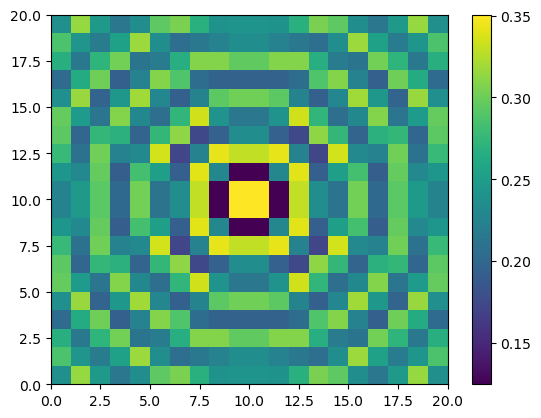

In [275]:
sino = to_device(xp.ones(img_fwd.shape, dtype=xp.float32), dev)
back_img = parallelproj.joseph3d_back(xstart, xend, img_dim, img_origin,
                                      voxel_size, sino)
plt.pcolormesh(back_img[:,:,10])
plt.colorbar()


Save the listmode to binary:

In [260]:
detectors = []
for i in range(N_detectors):
    detectors.append(prd.Detector(id=i, x=x_pos[i], y=y_pos[i], z=z_pos[i]))
scanner_information = prd.ScannerInformation(detectors=detectors)

events = []
for count, detector1, detector2 in zip(img_fwd_realization, detectors1, detectors2):
    for _ in range(count):
        events.append(CoincidenceEvent(detector_1_id=int(detector1), detector_2_id=int(detector2)))
time_block = TimeBlock(id=0, prompt_events=events)

with prd.BinaryPrdExperimentWriter('paraproj_data.bin') as writer:
    writer.write_header(prd.Header(scanner=scanner_information))
    writer.write_time_blocks(
        (time_block,)
    )


Open data and backproject:

In [261]:
detectors1, detectors2, counts = PRD2Numpy('paraproj_data.bin')


TODO tomorrow: dictionary to go from detector ID to position